In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import os
import re
import openpyxl
import matplotlib.pyplot as plt

# Indlæs data

In [125]:
# 1. Lav en liste over de specifikke filnavne
# Vi leder efter filer, der starter med 'PLC'
folder = Path('C:/Users/tobi4/OneDrive - Aarhus universitet/UNI/4. Semester/Dataprojekt/2023 AAR vaskeri data')
files = list(folder.glob("PLC*.xlsx"))


# Sørg for at 'Maj' er med her
month_map = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'Maj': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Okt': 10, 'Nov': 11, 'Dec': 12
}

# Og sørg for at 'Maj' er med i din Regex her:
regex_pattern = r"(Jan|Feb|Mar|Apr|Maj|Jun|Jul|Aug|Sep|Okt|Nov|Dec)"


data = []
for f in files:
    temp_df = pd.read_excel(f, skiprows=2)
    temp_df["source_file"] = f.name  
    data.append(temp_df)

## Samlet data

In [126]:
all_data = pd.concat(data, ignore_index=True)

print(f"Filer indlæst: {len(files)}")
print(f"{all_data.shape[0]} rækker og {all_data.shape[1]} kolonner i det samlede Dataframe.")
print(f"Med kolonnerne: {(all_data.columns)}")

# Vis de første rækker af det samlede Dataframe
print(all_data.keys())
print(all_data.head())

Filer indlæst: 12
248711 rækker og 7 kolonner i det samlede Dataframe.
Med kolonnerne: Index(['Produkt - Produkt', 'Kassationsårsag (ui)',
       'Stk. tøj per kassationsdato', 'Dage i cirkulation', 'Total antal vask',
       'Unik Kode (ui)', 'source_file'],
      dtype='str')
Index(['Produkt - Produkt', 'Kassationsårsag (ui)',
       'Stk. tøj per kassationsdato', 'Dage i cirkulation', 'Total antal vask',
       'Unik Kode (ui)', 'source_file'],
      dtype='str')
                   Produkt - Produkt          Kassationsårsag (ui)  \
0     06360 Bagerskjorte HV. L/Æ P/B  Kass. af RETUR,MINIMU,afmeld   
1  03655 Skjorte Bager HV.K/Æ P/B CC       Alm.slid uden restværdi   
2           04290 Skjorte Marine P/B     Misligholdt med restværdi   
3    03982 Jakke hyg kina 2 indv lom                  Udgået Model   
4   04969 Vaskenet 50X70 Hvid M Fane  Kass. af RETUR,MINIMU,afmeld   

   Stk. tøj per kassationsdato  Dage i cirkulation  Total antal vask  \
0                            1      

248.711 rækker og 7 kolonner i det samlede Dataframe.

### Gentagelser af "Unikke koder"

In [128]:
n_unique_prod_year = (
    all_data
    .dropna(subset=["Unik Kode (ui)"])
    .groupby("Unik Kode (ui)")["Produkt - Produkt"] #group by ui and look at product for each group
    .nunique() #counting how many products each ui maps to
)
bad_ui_year = n_unique_prod_year[n_unique_prod_year > 1].index #filter for only conflicting ui's

conflicts_year = (
            all_data[all_data["Unik Kode (ui)"].isin(bad_ui_year)] #selecting rows which ui's are non-unique
            .loc[:, ["Unik Kode (ui)", "Produkt - Produkt", "source_file"]] # selecting only the stated rows
            .drop_duplicates() #dropping duplicates of bad ui's (same prod, same ui, same file)
            .sort_values(["Unik Kode (ui)", "Produkt - Produkt"]) #sorting for readability
        )

print("Number of conflicting UI codes in full dataset:", len(bad_ui_year))
conflicts_year.head(7)

Number of conflicting UI codes in full dataset: 439


,Unik Kode (ui),Produkt - Produkt,source_file
83199,00D007440139,09182 Overall Kblå Hygiejne,"PLC, Product detaljeret, Aarhus, Jan. 2023.xlsx"
100711,00D007440139,23361 Overall Food Kblå,"PLC, Product detaljeret, Aarhus, Jan. 2023.xlsx"
26700,00D0075C79CB,06325 Kokkebuss. Brod. Grå P/B,"PLC, Product detaljeret, Aarhus, Aug. 2023.xlsx"
228354,00D0075C79CB,06325 Kokkebuss. Brod. Grå P/B,"PLC, Product detaljeret, Aarhus, Okt. 2023.xlsx"
39935,00D0075C79CB,30206 Jakke Løvbjerg sort,"PLC, Product detaljeret, Aarhus, Aug. 2023.xlsx"
55818,00D0085C7770,01806 Jakke Termo Marineblå,"PLC, Product detaljeret, Aarhus, Feb. 2023.xlsx"
79324,00D0085C7770,23897 Termojakke u/lom mblå,"PLC, Product detaljeret, Aarhus, Feb. 2023.xlsx"


In [ ]:
# print(all_data['Month'])
# print("\n")
# print(all_data['Month_map'].unique())

# all_data['source_file'].str.extract(r'(\w{3})\. \d{4}\.xlsx')[0].unique()

### Plot/ Tabel

In [132]:
# 2. Filtrer all_data for kun at beholde de koder, der har konflikter
conflicts_raw = all_data[all_data["Unik Kode (ui)"].isin(bad_ui_year)]

# 3. Aggreger til én række pr. kode med lister
# Vi bruger .unique() på produktnavne for at se de forskellige navne, 
# men beholder hele historikken for dage og årsager.
conflicts_grouped = (
    conflicts_raw
    .groupby("Unik Kode (ui)")
    .agg({
        "Produkt - Produkt": lambda x: list(x.unique()),
        "Dage i cirkulation": list,
        "Kassationsårsag (ui)": list,
        "source_file": list
    })
    .reset_index()
)

# Omdøb kolonner for klarhed
conflicts_grouped.columns = ["Unik Kode (ui)", "Produktnavne", "Dage_Historik", "Aarsager_Historik", "Måned"]

conflicts_grouped.head(10)

,Unik Kode (ui),Produktnavne,Dage_Historik,Aarsager_Historik,Måned
0,00D007440139,"[09182 Overall Kblå Hygiejne, 23361 Overall Fo...","[1626, 0]","[Udgået Model, Udgået Model]","[PLC, Product detaljeret, Aarhus, Jan. 2023.xl..."
1,00D0075C79CB,"[06325 Kokkebuss. Brod. Grå P/B, 30206 Jakke L...","[1361, 0, 0]","[BTS fejl uden restværdi, BTS fejl uden restvæ...","[PLC, Product detaljeret, Aarhus, Aug. 2023.xl..."
2,00D0085C7770,"[01806 Jakke Termo Marineblå, 23897 Termojakke...","[3997, 0]","[Misligholdt med restværdi, BTS fejl uden rest...","[PLC, Product detaljeret, Aarhus, Feb. 2023.xl..."
3,00D0085D8F1F,"[09182 Overall Kblå Hygiejne, 23361 Overall Fo...","[743, 0]","[Udgået Model, Udgået Model]","[PLC, Product detaljeret, Aarhus, Jan. 2023.xl..."
4,00D00960C27E,"[10129 Overall FlmQ so/grå brystlom, 25995 Ove...","[98, 0]","[Udgået Model, Alm.slid uden restværdi]","[PLC, Product detaljeret, Aarhus, Feb. 2023.xl..."
5,00D009AFC9AD,"[22571 Dunjakke Outdoor C uni sort, 13694 Jakk...","[445, 60]","[Udgået Model, Udgået Model]","[PLC, Product detaljeret, Aarhus, Feb. 2023.xl..."
6,00D009E24B0F,"[14147 Jakke 2 indvlom hv high risk, 14141 Jak...","[0, 38]","[Videresalg til kunder, Misligholdt med restvæ...","[PLC, Product detaljeret, Aarhus, Feb. 2023.xl..."
7,00D00A2B05E2,"[25996 Buks FlamePro NY sort/grå, 13210 Benklæ...","[27, 1756]","[Misligholdt med restværdi, Udgået Model]","[PLC, Product detaljeret, Aarhus, Apr. 2023.xl..."
8,00D00A57D4D1,"[09195 Overall M.Knæl Grå/Sort Bom, 02813 Over...","[0, 0]","[Udgået Model, Udgået Model]","[PLC, Product detaljeret, Aarhus, Dec. 2023.xl..."
9,00D00A5CFA2D,"[09182 Overall Kblå Hygiejne, 23361 Overall Fo...","[399, 262]","[Udgået Model, Udgået Model]","[PLC, Product detaljeret, Aarhus, Jan. 2023.xl..."


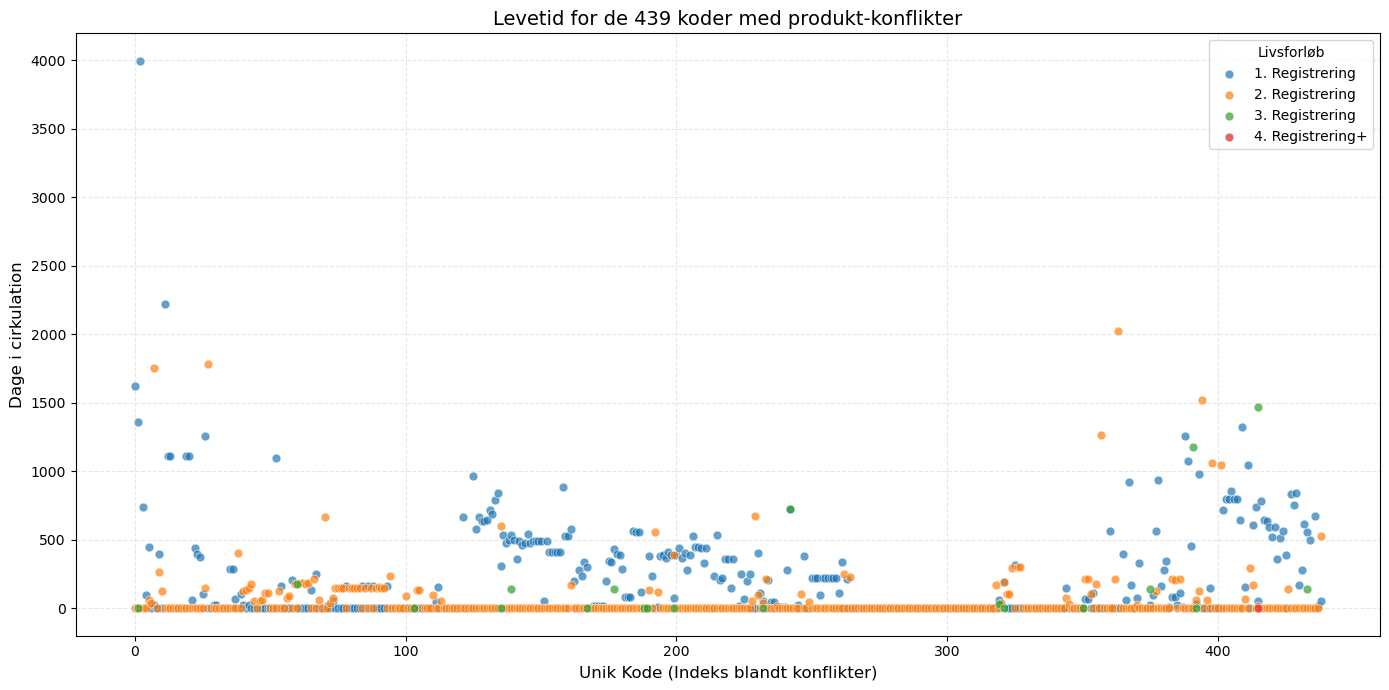

In [133]:
# 4. Forbered data til scatterplot (Kun for konflikterne)
plot_data = []
for i, row in conflicts_grouped.iterrows():
    for index, dage in enumerate(row['Dage_Historik']):
        plot_data.append({
            'ID_Index': i, 
            'Dage': dage, 
            'Liv_Nummer': index + 1
        })

plot_df = pd.DataFrame(plot_data)

# 5. Generer scatterplot
plt.figure(figsize=(14, 7))
colors = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c', 4: '#d62728'}
labels = {1: '1. Registrering', 2: '2. Registrering', 3: '3. Registrering', 4: '4. Registrering+'}

for life in sorted(plot_df['Liv_Nummer'].unique()):
    subset = plot_df[plot_df['Liv_Nummer'] == life]
    plt.scatter(subset['ID_Index'], subset['Dage'], 
                color=colors.get(life, 'black'), 
                label=labels.get(life), 
                alpha=0.7, s=40, edgecolors='w', linewidth=0.5)

plt.title(f'Levetid for de {len(conflicts_grouped)} koder med produkt-konflikter', fontsize=14)
plt.xlabel('Unik Kode (Indeks blandt konflikter)', fontsize=12)
plt.ylabel('Dage i cirkulation', fontsize=12)
plt.legend(title="Livsforløb")
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Vis de første 10 rækker af den nye tabel
# print(f"Tabel over de {len(conflicts_grouped)} koder med konflikter:")
# conflicts_grouped.head(10)

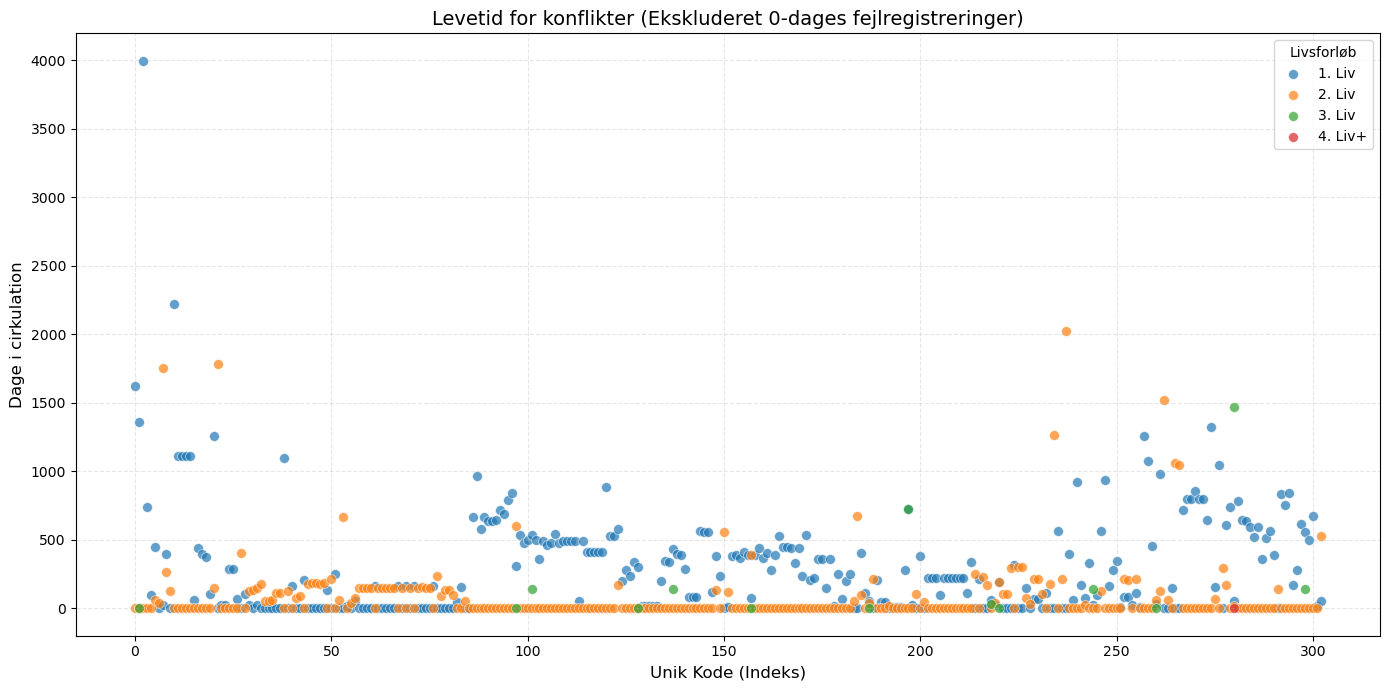

Oprindelige konflikter: 439
Konflikter efter fjernelse af 0-dages registreringer: 303


In [135]:
# 2. Aggregering til én række pr. UI
conflicts_raw = all_data[all_data["Unik Kode (ui)"].isin(bad_ui_year)].copy()
# Vi sikrer os at de er sorteret efter måned (Month_Num skal være oprettet tidligere)
conflicts_raw = conflicts_raw.sort_values(['Unik Kode (ui)', 'source_file'])

conflicts_grouped = (
    conflicts_raw
    .groupby("Unik Kode (ui)")
    .agg({
        "Produkt - Produkt": lambda x: list(x.unique()),
        "Dage i cirkulation": list,
        "Kassationsårsag (ui)": list
    })
    .reset_index()
)

# 3. FILTRERING: Fjern dem med 0 i både 1. og 2. levetid
# Vi definerer en maske der finder dem hvor både første (index 0) og anden (index 1) værdi er 0
mask_both_zero = (
    conflicts_grouped['Dage i cirkulation'].apply(lambda x: x[0] if len(x) > 0 else None) == 0
) & (
    conflicts_grouped['Dage i cirkulation'].apply(lambda x: x[1] if len(x) > 1 else None) == 0
)

# Vi beholder kun dem der IKKE (~) matcher masken
conflicts_filtered = conflicts_grouped[~mask_both_zero].copy()

# 4. Forbered data til scatterplot (Nu med det filtrerede sæt)
plot_data = []
for i, row in conflicts_filtered.reset_index().iterrows():
    for index, dage in enumerate(row['Dage i cirkulation']):
        plot_data.append({
            'ID_Index': i, 
            'Dage': dage, 
            'Liv_Nummer': index + 1
        })

plot_df = pd.DataFrame(plot_data)

# 5. Scatterplot over de reelle konflikter
plt.figure(figsize=(14, 7))
colors = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c', 4: '#d62728'}
labels = {1: '1. Liv', 2: '2. Liv', 3: '3. Liv', 4: '4. Liv+'}

for life in sorted(plot_df['Liv_Nummer'].unique()):
    subset = plot_df[plot_df['Liv_Nummer'] == life]
    plt.scatter(subset['ID_Index'], subset['Dage'], 
                color=colors.get(life, 'black'), 
                label=labels.get(life), 
                alpha=0.7, s=50, edgecolors='w', linewidth=0.5)

plt.title(f'Levetid for konflikter (Ekskluderet 0-dages fejlregistreringer)', fontsize=14)
plt.xlabel('Unik Kode (Indeks)', fontsize=12)
plt.ylabel('Dage i cirkulation', fontsize=12)
plt.legend(title="Livsforløb")
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Oprindelige konflikter: {len(conflicts_grouped)}")
print(f"Konflikter efter fjernelse af 0-dages registreringer: {len(conflicts_filtered)}")

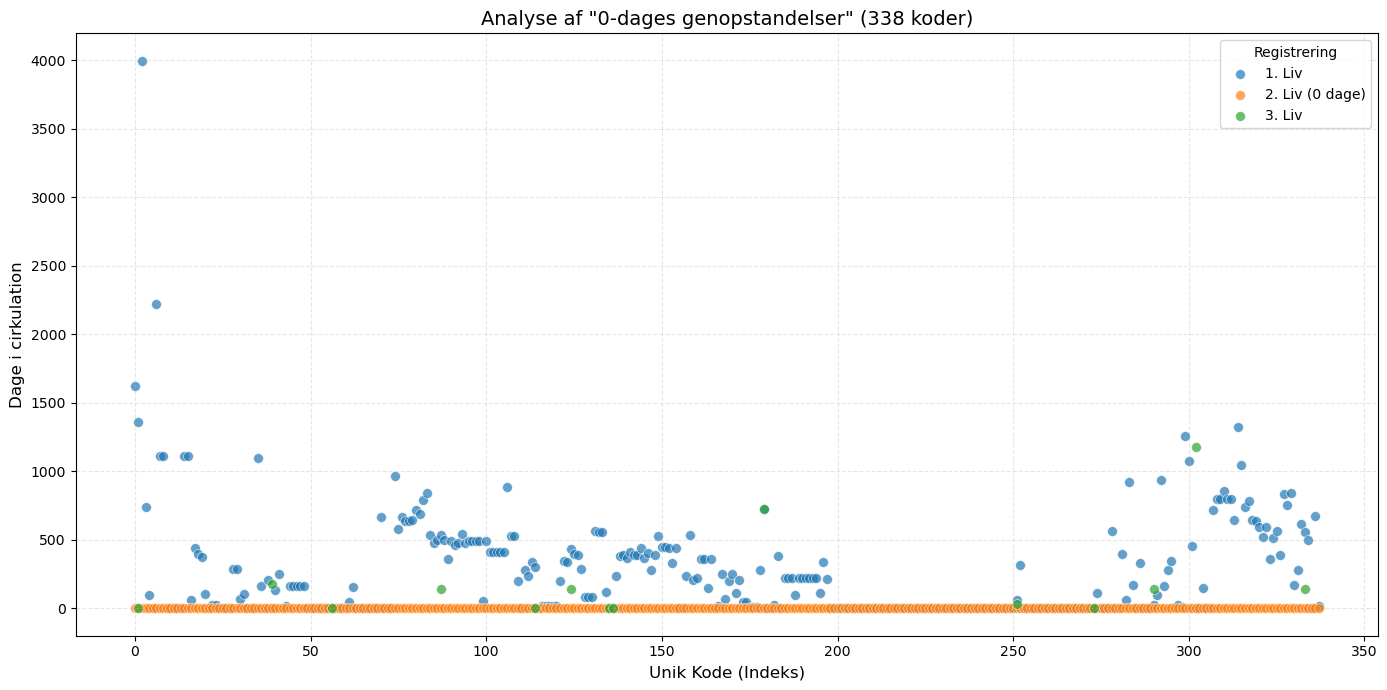

Antal koder hvor 2. liv er præcis 0 dage: 338


In [136]:
# 1. Brug din eksisterende 'conflicts_grouped' tabel
# Vi filtrerer for koder, der har mindst to registreringer, hvor den anden er 0
mask_second_life_zero = (
    conflicts_grouped['Dage i cirkulation'].apply(lambda x: len(x) > 1 and x[1] == 0)
)

conflicts_zero_second = conflicts_grouped[mask_second_life_zero].copy()

# 2. Forbered data til plot
plot_data_zero = []
for i, row in conflicts_zero_second.reset_index().iterrows():
    for index, dage in enumerate(row['Dage i cirkulation']):
        plot_data_zero.append({
            'ID_Index': i, 
            'Dage': dage, 
            'Liv_Nummer': index + 1
        })

plot_df_zero = pd.DataFrame(plot_data_zero)

# 3. Generer scatterplot
plt.figure(figsize=(14, 7))
colors = {1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c', 4: '#d62728'}
labels = {1: '1. Liv', 2: '2. Liv (0 dage)', 3: '3. Liv', 4: '4. Liv+'}

for life in sorted(plot_df_zero['Liv_Nummer'].unique()):
    subset = plot_df_zero[plot_df_zero['Liv_Nummer'] == life]
    plt.scatter(subset['ID_Index'], subset['Dage'], 
                color=colors.get(life, 'black'), 
                label=labels.get(life), 
                alpha=0.7, s=50, edgecolors='w', linewidth=0.5)

plt.title(f'Analyse af "0-dages genopstandelser" ({len(conflicts_zero_second)} koder)', fontsize=14)
plt.xlabel('Unik Kode (Indeks)', fontsize=12)
plt.ylabel('Dage i cirkulation', fontsize=12)
plt.legend(title="Registrering")
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Antal koder hvor 2. liv er præcis 0 dage: {len(conflicts_zero_second)}")

## Stk. tøj $>1$

In [137]:
# Filtrering 
Stktoej = all_data[all_data["Stk. tøj per kassationsdato"] > 1]

# Sortering efter antal
Stktoej_tabel = (
    Stktoej[["Unik Kode (ui)", "Produkt - Produkt", "Kassationsårsag (ui)", "Stk. tøj per kassationsdato"]]
    .sort_values(by="Stk. tøj per kassationsdato", ascending=False)
)

print(f"Antal rækker med \"Stk. tøj per kassationsdato\" (>1 stk): {len(Stktoej)}")
# print("\nDe største kassationer i datasættet:")
# print(Stktoej_tabel.head(15))

print(Stktoej["Kassationsårsag (ui)"].value_counts())

# print(Stktoej[["Kassationsårsag (ui)", "Month_map"]].value_counts().sort_values(ascending=False))

Antal rækker med "Stk. tøj per kassationsdato" (>1 stk): 553
Kassationsårsag (ui)
Udgået Model                           463
Alm.slid uden restværdi                 45
BTS fejl uden restværdi                 43
Produktfejl                              1
Ødelagt af lommefyld uden restværdi      1
Name: count, dtype: int64


In [ ]:
# Skab en læsbar matrix-tabel (Crosstab)
# index er rækkerne, columns er kolonnerne
tabel_oversigt = pd.crosstab(
    index=Stktoej["Kassationsårsag (ui)"], 
    columns=Stktoej["source_file"].str.extract(r'(\w{3})[.,\s]+\d{4}')[0],  # Ekstraher månedsnavn fra filnavn - r'(\w{3})\. \d{4}\.xlsx'
    margins=True,            # Tilføjer en 'All' kolonne/række med totaler
    margins_name="TOTAL"     # Navnet på total-rækken
)

# print(f"Antal rækker med bulk-kassation (>1 stk): {len(Stktoej)}")
print("Oversigt over kassationer per måned:")
display(tabel_oversigt) 

Oversigt over kassationer per måned:


,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Maj,Mar,Nov,Okt,Sep,TOTAL
Kassationsårsag (ui),,,,,,,,,,,,,
Alm.slid uden restværdi,0,0,2,0,0,36,2,1,0,0,4,0,45
BTS fejl uden restværdi,1,3,7,0,11,2,5,7,1,2,3,1,43
Produktfejl,0,0,0,0,1,0,0,0,0,0,0,0,1
Udgået Model,24,16,7,95,64,12,27,60,79,2,28,49,463
Ødelagt af lommefyld uden restværdi,0,0,0,0,0,0,1,0,0,0,0,0,1
TOTAL,25,19,16,95,76,50,35,68,80,4,35,50,553


In [159]:
andel = (len(Stktoej) / len(all_data) * 100)
print(f"Andel af rækker med \"Stk. tøj per kassationsdato\" > 1: \n{len(Stktoej)} / {len(all_data)} * 100 = {andel:.2f}%")

Andel af rækker med "Stk. tøj per kassationsdato" > 1: 
553 / 248711 * 100 = 0.22%
